In [1]:
import trajectory as traj
import matplotlib.pyplot as plt 
import numpy as np
import cvxopt

In [2]:
def test_traj(traj,t):
    [poly_duration,poly_x,poly_y,poly_z,poly_yaw] = traj.get_poly()
    
    res_x = 0
    res_y = 0
    res_z = 0
    for i in range(len(poly_x)):
        res_x = res_x*t + poly_x[len(poly_x)-1-i]
        res_y = res_y*t + poly_y[len(poly_y)-1-i]
        res_z = res_z*t + poly_z[len(poly_z)-1-i]
    
    res_vx = 0
    res_vy = 0
    res_vz = 0
    # pos = x0 + x1*t + x2*t^2 + ...... + x7*t^7
    # vel = x1 + 2*x2*t + 3*x3*t^2 + ......+ 7*x7*t^6
    for i in range(1,len(poly_x),1):
        # print(len(poly_x)-i)
        res_vx = res_vx*t + (len(poly_x)-i)*poly_x[len(poly_x)-i]
        res_vy = res_vy*t + (len(poly_y)-i)*poly_y[len(poly_y)-i]
        res_vz = res_vz*t + (len(poly_z)-i)*poly_z[len(poly_z)-i]
    
    res_ax = 0
    res_ay = 0
    res_az = 0
    # pos = x0 + x1*t + x2*t^2 + ...... + x7*t^7
    # vel = x1 + 2*x2*t + 3*x3*t^2 + ......+ 7*x7*t^6
    # acc = 1*2*x2 + 2*3*x3*t + 3*4*x4*t^2 + ...... + 6*7*x7*t^5
    for i in range(2,len(poly_x),1):
        res_ax = res_ax*t + (len(poly_x)-i)*(len(poly_x)-i+1)*poly_x[len(poly_x)+1-i]
        res_ay = res_ay*t + (len(poly_y)-i)*(len(poly_y)-i+1)*poly_y[len(poly_y)+1-i]
        res_az = res_az*t + (len(poly_z)-i)*(len(poly_z)-i+1)*poly_z[len(poly_z)+1-i]
        
    
    result = [res_x,res_y,res_z,res_vx,res_vy,res_vz,res_ax,res_ay,res_az]
    
    return np.around(result,decimals=6)

In [3]:
def polynomial_cvxopt_2(t,pos,vel,degree=7):

    punishment = 0
    degree_standard = 7
    
    total_time = t[-1]
    
    punish_matrix = np.matlib.eye(degree+2)
    
    T = np.matrix(t).T
    
    Q = np.matlib.zeros((len(T),degree+1))
    Q[:, degree ] = 1
    for i in range(degree-1,-1,-1):
        Q[:,i]= np.multiply(T,Q[:,i+1])
    
    Real_Pos = np.matrix(pos).T
    #Real_Vel = np.matrix(vel).T
    
    ExQ = np.append(-Real_Pos,Q,axis=1)
    H = 0.5*( ExQ.T*ExQ + punishment*punish_matrix )
    
    Aeq = np.matlib.zeros( (4, degree+2) )
    Aeq[0,:] = np.append(0,Q[0,:])
    Aeq[1,:] = np.append(0,Q[-1,:])
    Aeq[2, degree ] = 1
    #for i in range(degree+1, 0, -1):
    #    Aeq[3,i] = (degree+1-i)*total_time**(degree-i)
    Aeq[3,0] = 1
    
    beq = [Real_Pos[0,0], Real_Pos[-1,0], vel,1]
    
    P = cvxopt.matrix(H.tolist())
    A = cvxopt.matrix(Aeq.T.tolist())
    b = cvxopt.matrix(beq)
    
    q = cvxopt.matrix([0.0 for i in range(degree+2)])
    G = cvxopt.matrix([0.0 for i in range(degree+2)],(1,degree+2))
    h = cvxopt.matrix([1.0])

    cvxopt.solvers.options['show_progress'] = False
    result = cvxopt.solvers.qp(P,q,G,h,A,b)
    res = list(result['x'])[1:]
    
    res2 = []
    for i in range(degree_standard-degree):
        res2.append(0)
    res = res2 + res
    
    return np.around(res, decimals=6)

In [4]:
class traj_poly:
    def __init__(self,duration,poly_x,poly_y,poly_z,poly_yaw=np.zeros(8)):
        self.duration = duration
        self.poly_x = poly_x
        self.poly_y = poly_y
        self.poly_z = poly_z
        self.poly_yaw = poly_yaw
        
    def get_poly(self):
        return [self.duration,self.poly_x,self.poly_y,self.poly_z,self.poly_yaw]


In [5]:
def traj_generator_2(t,x,y,z,vx,vy,vz):
    trajs = []
    
    temp_vx = vx[0][0]
    temp_vy = vy[0][0]
    temp_vz = vz[0][0]

    for i in range(len(t)):
        duration = np.around(max(t[i]) - min(t[i]),6)
        poly_x = polynomial_cvxopt_2(t[i],x[i],temp_vx, degree=7)
        poly_y = polynomial_cvxopt_2(t[i],y[i],temp_vy, degree=7)
        poly_z = polynomial_cvxopt_2(t[i],z[i],temp_vz, degree=7)
        
        # Flip the order of the coefficient of the polynomial
        # true format : [x^0, x^1, x^2,..., x^7]
        poly_x = np.flipud(poly_x)
        poly_y = np.flipud(poly_y)
        poly_z = np.flipud(poly_z)
        
        polynomial = traj_poly(duration, poly_x, poly_y, poly_z)
        
        temp_vx = test_traj(polynomial,duration)[3]
        temp_vy = test_traj(polynomial,duration)[4]
        temp_vz = test_traj(polynomial,duration)[5]
        
        trajs.append(polynomial)
    return trajs

In [7]:
def plot_vel(trajs):
    step = 0.01
    time = []
    velocity_x = []
    velocity_y = []
    for i in range(len(trajs)):
        duration = trajs[i].get_poly()[0]
        t = np.linspace(0, duration, int(duration/step)+1)
        vel_x = []
        vel_y = []
        for j in t:
            term = test_traj(trajs[i],j)[3]
            term2 = test_traj(trajs[i],j)[4]
            vel_x.append(term)
            vel_y.append(term2)
            
        time.append(t)
        velocity_x.append(vel_x)
        velocity_y.append(vel_y)
    
    total_time = 0
    for i in time:
        total_time += len(i)
    time_draw = np.linspace(0,(total_time-1)*step,total_time)
    
    vel_x_draw = []
    for i in velocity_x:
        for j in i:
            vel_x_draw.append(j)
            
    vel_y_draw = []
    for i in velocity_y:
        for j in i:
            vel_y_draw.append(j)

    fig = plt.figure()
    plt.plot(time_draw,vel_x_draw)
    plt.plot(time_draw,vel_y_draw)
    plt.show()

In [6]:
input_name = "./5000/SinglePointRobot2D_5s_5000.txt"
raw_data = traj.read_file(input_name)
multi_raw_trajs = traj.multi_traj_process(raw_data)

trajs = []
#trajs2 = []

t = []
x = []
y = []
z = []
vx = []
vy = []
vz =[]
for traj_single in multi_raw_trajs:
    t,origin,x,y,z,vx,vy,vz = traj.traj_get_xyz(traj_single,400)
    trajs.append(traj_generator_2(t,x,y,z,vx,vy,vz))
    #trajs2.append(traj_generator(t,x,y,z))

the origin (x,y,z) = (-1.500,-1.500,2.000)


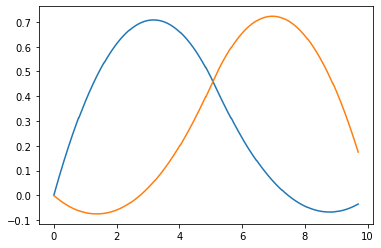

In [9]:
plot_vel(trajs[0])